In [54]:
# Imports
import scipy
from scipy.signal import windows, welch
from scipy.signal.windows import dpss
from scipy.fft import fft, fftfreq
import numpy as np
import math
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from spectral_connectivity import Multitaper, Connectivity

# Generating Data

In [55]:
def generate_data(random_state = 42, duration=30):
    data = spectrum(
        sampling_rate=1000,
        duration=duration,
        aperiodic_exponent=2.0,
        aperiodic_offset=2.0,
        knee=200,
        peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
        average_firing_rate=0.0,
        random_state=random_state,
        direct_estimate=False,
        plot=False
    )
    return data

data = generate_data()
data_td = data.time_domain.combined_signal
data_fd = data.frequency_domain

# Single Taper (Package)

In [51]:
from scipy.signal import periodogram
def single_taper(signal, window_length, taper_shape, fs=1000):
    freqs, psd = periodogram(signal, window_length, taper_shape, fs)
    return np.log(freqs), 10*np.log(psd)

# Multitaper

In [56]:
def multitaper(signal, TW = 1, K = 1, fs=1000):
    K = 2*TW-1 
    mt = Multitaper(time_series = signal, sampling_frequency = fs, time_halfbandwidth_product=TW, n_tapers = K)
    connectivity = Connectivity.from_multitaper(mt)
    freqs = connectivity.frequencies
    power = connectivity.power().squeeze()
    return np.log(freqs), 10*np.log(power)

# Example Run / Tangible Scaling Visualization Plot

/var/folders/qc/gskc2tx57z1gs3hq4hy86wfc0000gn/T/ipykernel_8204/1641665386.py:4: RuntimeWarning: divide by zero encountered in log10
  return np.apply_along_axis(lambda x: np.log10(x), 0, freqs), 10*np.apply_along_axis(lambda x: 10*np.log10(x), 0, psd)
/var/folders/qc/gskc2tx57z1gs3hq4hy86wfc0000gn/T/ipykernel_8204/501869862.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(freqs), 10*np.log(power)


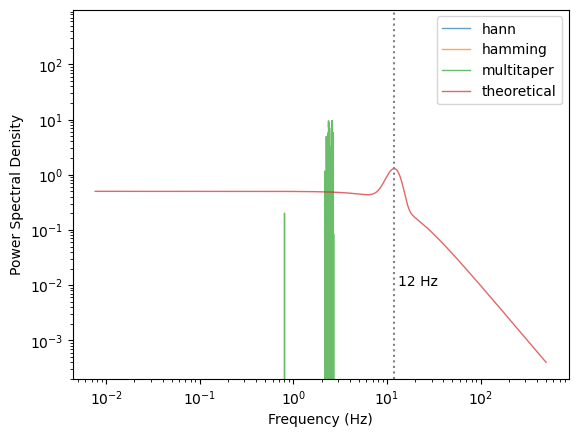

In [58]:
theoretical_freqs_pos = data_fd.frequencies[data_fd.frequencies > 0]
theoretical_psds_pos = data_fd.combined_spectrum[data_fd.frequencies > 0]

window_length = 0.05
freq_hann, psd_hann = single_taper(data_td, window_length=window_length, taper_shape='hann')
freq_hamming, psd_hamming = single_taper(data_td, window_length=window_length, taper_shape='hamming')
freq_mt, psd_mt = multitaper(data_td, TW=3)


plt.plot(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann')
plt.plot(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
plt.plot(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper')
plt.loglog(theoretical_freqs_pos, theoretical_psds_pos, linewidth=1, alpha=0.7, label='theoretical')

plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 0.01,'12 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

# Bias

In [148]:
# Calculate Bias

def calc_mean_bias(empiricalPSD, theoreticalPSD):
    N = len(theoreticalPSD)
    empiricalPSD = empiricalPSD[:-1] if (len(empiricalPSD) > N) else empiricalPSD
    biases = np.abs(empiricalPSD - theoreticalPSD) # do we need to change this cuz the empirical length is 251 while theoretical length is 250
    meanBias = np.sum(biases)/N

    return meanBias

In [149]:
def get_correct_theoretical_window(psd_theoretical_fd, freq_theoretical_fd, freq_empirical):
    """
    Interpolates theoretical PSD onto empirical frequency axis.
    """
    from scipy.interpolate import interp1d
    interpolator = interp1d(freq_theoretical_fd, psd_theoretical_fd, bounds_error=False, fill_value=np.nan)
    return interpolator(freq_empirical)

In [150]:
def calculate_biases(df, window_length, TW, data):
    for random_state in range(50): # generate data multiple times
        data = generate_data(random_state=random_state)
        data_td = data.time_domain.combined_signal
        data_fd = data.frequency_domain
        freq_hann, psd_hann = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hann')
        freq_hamming, psd_hamming = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hamming')
        freq_mt, psd_mt = multitaper(data_td, window_length=window_length, TW=TW)

        psd_theoretical_correct_window = get_correct_theoretical_window(data_fd.combined_spectrum, data_fd.frequencies, freq_hamming)
        psd_theoretical_correct_window_mt = get_correct_theoretical_window(data_fd.combined_spectrum, data_fd.frequencies, freq_mt)
        

        df.loc[len(df)] = [window_length,
                        TW,
                        calc_mean_bias(psd_hamming, psd_theoretical_correct_window),
                        calc_mean_bias(psd_hann, psd_theoretical_correct_window), 
                        calc_mean_bias(psd_mt, psd_theoretical_correct_window_mt)]
    return df

# df = pd.DataFrame(columns=['window', 'TW', 'hamming_mean_bias', 'hann_mean_bias', 'multitaper_mean_bias'])

# for window_length in [0.01, 0.05, 0.1, 0.2, 0.5, 1]
#     for TW in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
#         df = calculate_biases(df=df, window_length=window_length, TW=TW, data=data)

In [151]:
# df.head()

In [152]:
#df.to_csv('taper_comparisons_windowlength=0.01.csv', index=False)

# Raw Data Processing!

https://physionet.org/content/sleep-edfx/1.0.0/

In [153]:
import mne
file_path = "./ST7011J0-PSG.edf"
raw = mne.io.read_raw_edf(file_path, preload=True) # preload=True loads data into memory
data = raw.get_data() # Access the signal data
info = raw.info # Access header information (channels, sampling rate, etc.)

Extracting EDF parameters from /Users/anikakumar/BU RISE/Project/spectral-analysis-comparison/ST7011J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3589999  =      0.000 ... 35899.990 secs...


/var/folders/qc/gskc2tx57z1gs3hq4hy86wfc0000gn/T/ipykernel_97239/830595987.py:3: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True) # preload=True loads data into memory
/var/folders/qc/gskc2tx57z1gs3hq4hy86wfc0000gn/T/ipykernel_97239/830595987.py:3: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True) # preload=True loads data into memory


In [154]:
import pandas as pd
print(data.T.shape)
df = pd.DataFrame(data.T, columns=raw.ch_names)

(3590000, 5)


In [155]:
data_real = df['EEG Fpz-Cz'][1100000:1200000] # get a certain arbitrary electrode

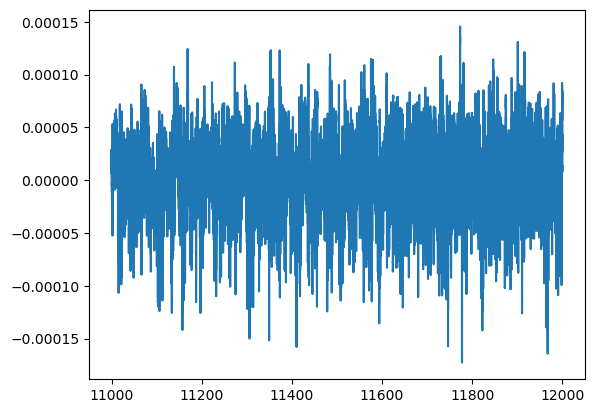

In [156]:
plt.plot((df.index/100)[1100000:1200000], df['EEG Fpz-Cz'][1100000:1200000])

In [157]:
real_data_sampling_frequency = 100 # Hz, samples/s
window_length_options = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5] # seconds
df_real = pd.DataFrame(columns=['window_length', 'taper_shape', 'freq, psd'])
for window_length in window_length_options:
    num_samples = int(window_length * real_data_sampling_frequency) # number of samples in window
    df_real.loc[len(df_real)] = [window_length, 'hann', single_taper_no_welch(data_real, window_length=window_length, taper_shape='hann')]
    df_real.loc[len(df_real)] = [window_length, 'hamming', single_taper_no_welch(data_real, window_length=window_length, taper_shape='hamming')]
    df_real.loc[len(df_real)] = [window_length, 'multitaper', multitaper_package_implementation(data_real, window_length=window_length, TW=1)]

In [158]:
df_real[['freq', 'psd']] = pd.DataFrame(df_real['freq, psd'].tolist(), index=df_real.index)

# Hann Graph

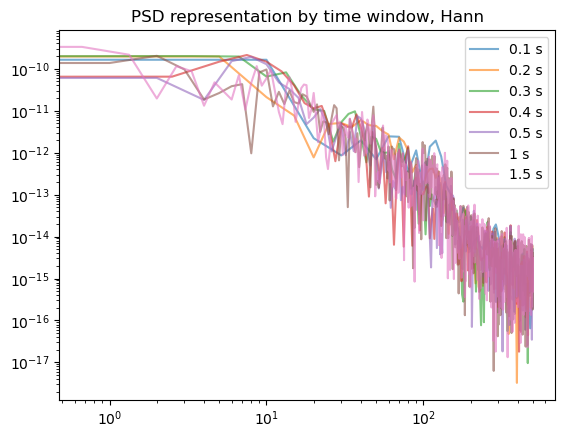

In [159]:
plt.title('PSD representation by time window, Hann')
for window_length in window_length_options:
    plt.loglog(df_real[(df_real['taper_shape'] == 'hann') & (df_real['window_length'] == window_length)]['freq'].iloc[0],
            df_real[(df_real['taper_shape'] == 'hann') & (df_real['window_length'] == window_length)]['psd'].iloc[0],
            label=f"{window_length} s",
            alpha=0.6)
plt.legend()

# Hamming Graph

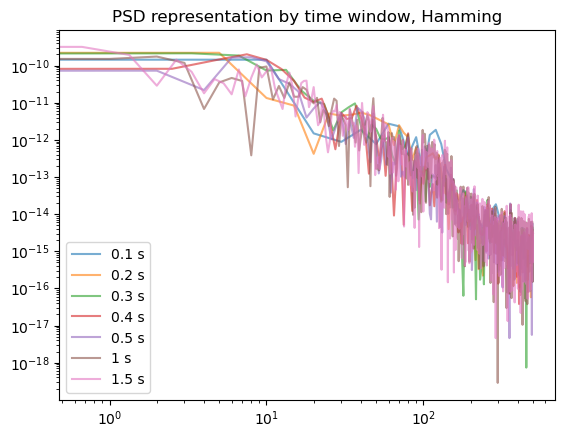

In [160]:
plt.title('PSD representation by time window, Hamming')
for window_length in window_length_options:
    plt.loglog(df_real[(df_real['taper_shape'] == 'hamming') & (df_real['window_length'] == window_length)]['freq'].iloc[0],
            df_real[(df_real['taper_shape'] == 'hamming') & (df_real['window_length'] == window_length)]['psd'].iloc[0],
            label=f"{window_length} s",
            alpha=0.6)
plt.legend()

# Multitaper Graph!

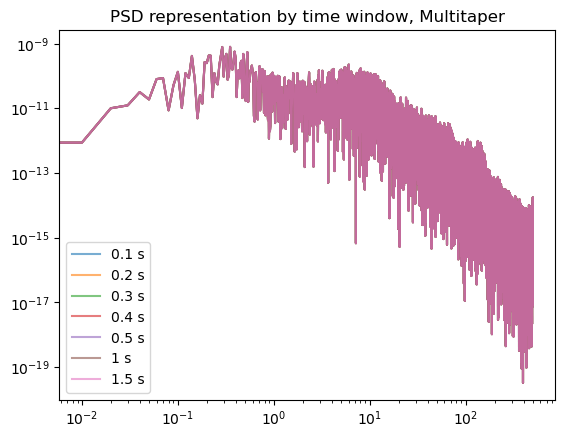

In [161]:
plt.title('PSD representation by time window, Multitaper')
for window_length in window_length_options:
    plt.loglog(df_real[(df_real['taper_shape'] == 'multitaper') & (df_real['window_length'] == window_length)]['freq'].iloc[0],
            df_real[(df_real['taper_shape'] == 'multitaper') & (df_real['window_length'] == window_length)]['psd'].iloc[0],
            label=f"{window_length} s",
            alpha=0.6)
plt.legend()